In [1]:
import json

with open('all_qguide_data.html', 'r') as file:
    json_data = json.load(file)

with open('all_qguide_data.json', 'w') as file:
    json.dump(json_data, file, separators=(',', ':'))


In [9]:
from bs4 import BeautifulSoup
from tabulate import tabulate
import pandas as pd
import requests
from functools import lru_cache

@lru_cache(maxsize=None)
def extract_table_data(url):
    response = requests.get(url)
    html = response.text

    soup = BeautifulSoup(html, 'html.parser')

    # Find the instructor name
    instructor_name = " ".join(soup.find('a', {'href': lambda x: x and x.startswith('#report')}).text.strip().split(" ")[7:9])

    # THIS PROBABLY IS BAD LONG-TERM BUT I"M FUCKING ANNOYED
    captions_to_skip = [
        "Table for [QTitle]-In this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic.-Statistics.",
        "Table for [QTitle]-In this course (including sections), I feel comfortable expressing my views on controversial topics.-Statistics.",
        "Table for [qtitle]-in this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic..",
        "Table for [qtitle]-in this course (including sections), i feel comfortable expressing my views on controversial topics..",
        "Table for [qtitle]-in this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic..",
    ]

    captions_to_skip = [caption.lower().strip() for caption in captions_to_skip]

    tables = soup.find_all('table')

    dataframes = {}

    table_index = 0

    for table in tables:
        caption_tag = table.find('caption')
        
        if caption_tag:
            caption_text = caption_tag.text.strip().lower()
            
            if any(skip_caption in caption_text for skip_caption in captions_to_skip):
                continue

        headers = [th.text.strip() for th in table.find('tr').find_all('th')]

        data = []
        for row in table.find_all('tr'):
            row_data = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
            if len(row_data) == len(headers):
                data.append(row_data)

        if len(data) > 1:
            df = pd.DataFrame(data[1:], columns=headers)
            # Add instructor name at the front
            df.insert(0, 'Instructor Name', instructor_name)
            dataframes[f'Table_{table_index}'] = df
            table_index += 1

    return dataframes


In [10]:
# Example usage:
url = "https://harvard.bluera.com/harvard/rpv-eng.aspx?lang=eng&redi=1&SelectedIDforPrint=2a25bbb354dd26d2a5018145b3eccac802438e93cb86651665bfd7dc8f5e8b888dcf958e60eb641327093338906fe195&ReportType=2&regl=en-US"
tables_data = extract_table_data(url)

# Print instructor name and each table with its name
for table_name, table_df in tables_data.items():
    print(f"Instructor: {table_df['Instructor Name'].iloc[0]}")
    print(f"Table '{table_name}':")
    print(tabulate(table_df, headers='keys', tablefmt='grid'))
    print()

Instructor: Glenda Carpio
Table 'Table_0':
+----+-------------------+----------------+------------+
|    | Instructor Name   | Raters         | Students   |
+====+===================+================+============+
|  0 | Glenda Carpio     | Responded      | 5          |
+----+-------------------+----------------+------------+
|  1 | Glenda Carpio     | Invited        | 7          |
+----+-------------------+----------------+------------+
|  2 | Glenda Carpio     | Response Ratio | 71%        |
+----+-------------------+----------------+------------+

Instructor: Glenda Carpio
Table 'Table_1':
+----+-------------------+--------------------------------------------------------------------------------------------+---------+-------------+-------------+--------+--------+------------------+---------------+------------+
|    | Instructor Name   |                                                                                            |   Count | Excellent   | Very Good   | Good   | Fair   | 

In [12]:
import json
import time
from concurrent.futures import ThreadPoolExecutor

with open('all_qguide_data.json', 'r') as f:
    all_qguide_data = json.load(f)

course_data_list = []

total_entries = len(all_qguide_data['data'])
processed_entries = 0
start_time = time.time()

def process_entry(entry):
    course_data = {key.capitalize(): entry[key] for key in ['title', 'url', 'instructor', 'department', 'term', 'subject', 'blueCourseId'] if key in entry}
    
    tables_data = extract_table_data(entry['url'])
    tables_data_dict = {table_name: table_df.to_dict(orient='records') for table_name, table_df in tables_data.items()}
    course_data['Feedback'] = tables_data_dict

    return course_data

def update_progress():
    global processed_entries
    processed_entries += 1
    percent_finished = (processed_entries / total_entries) * 100
    avg_time_per_iteration = (time.time() - start_time) / processed_entries
    remaining_entries = total_entries - processed_entries
    remaining_time_seconds = remaining_entries * avg_time_per_iteration

    hours = int(remaining_time_seconds // 3600)
    remaining_time_seconds %= 3600
    minutes = int(remaining_time_seconds // 60)
    seconds = int(remaining_time_seconds % 60)

    print(f"Iteration {processed_entries}/{total_entries} - {percent_finished:.2f}% completed - Estimated time remaining: {hours}h {minutes}m {seconds}s")

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = []
    for entry in all_qguide_data['data']:
        futures.append(executor.submit(process_entry, entry))

    for future in futures:
        course_data_list.append(future.result())
        update_progress()

with open('course_data.json', 'w') as json_file:
    json.dump(course_data_list, json_file, indent=4)


Iteration 1/11961 - 0.01% completed - Estimated time remaining: 24h 12m 0s
Iteration 2/11961 - 0.02% completed - Estimated time remaining: 12h 9m 32s
Iteration 3/11961 - 0.03% completed - Estimated time remaining: 8h 6m 18s
Iteration 4/11961 - 0.03% completed - Estimated time remaining: 6h 4m 42s
Iteration 5/11961 - 0.04% completed - Estimated time remaining: 4h 51m 44s
Iteration 6/11961 - 0.05% completed - Estimated time remaining: 4h 3m 5s
Iteration 7/11961 - 0.06% completed - Estimated time remaining: 3h 28m 21s
Iteration 8/11961 - 0.07% completed - Estimated time remaining: 3h 2m 17s
Iteration 9/11961 - 0.08% completed - Estimated time remaining: 2h 42m 1s
Iteration 10/11961 - 0.08% completed - Estimated time remaining: 2h 25m 48s
Iteration 11/11961 - 0.09% completed - Estimated time remaining: 2h 12m 32s
Iteration 12/11961 - 0.10% completed - Estimated time remaining: 2h 1m 29s
Iteration 13/11961 - 0.11% completed - Estimated time remaining: 1h 52m 8s
Iteration 14/11961 - 0.12% co

# This below section is not possible anymore because I forgot to scrape instructor names from 2019 :(

In [65]:
# import json

# def add_unique_courses(json1, json2):
#     # Create a set of Bluecourseid from the first JSON to keep track of added courses
#     existing_course_ids = {course['Bluecourseid'] for course in json1}
    
#     # Loop through the second JSON and add courses that don't exist in the first
#     for course in json2:
#         if course['Bluecourseid'] not in existing_course_ids:
#             json1.append(course)  # Add the new course to the first JSON
    
#     return json1

# # Load JSON data from files
# with open('course_data.json', 'r') as file1:
#     json1 = json.load(file1)

# with open('new_course_data.json', 'r') as file2:
#     json2 = json.load(file2)

# # Add unique courses from json2 to json1
# combined_json = add_unique_courses(json1, json2)

# # Save the combined JSON array
# with open('2020-2024_Course_Data.json', 'w') as outfile:
#     json.dump(combined_json, outfile, indent=4)


Data sample:
  Instructor Name          Raters Students  \
0     Sarah Lewis       Responded       18   
1     Sarah Lewis         Invited       24   
2     Sarah Lewis  Response Ratio      75%   
3     Sarah Lewis             NaN      NaN   
4     Sarah Lewis             NaN      NaN   

                                               Title  \
0  AAAS 112-Black Art and the Refounding of Ameri...   
1  AAAS 112-Black Art and the Refounding of Ameri...   
2  AAAS 112-Black Art and the Refounding of Ameri...   
3  AAAS 112-Black Art and the Refounding of Ameri...   
4  AAAS 112-Black Art and the Refounding of Ameri...   

                                                 Url Instructor  \
0  https://harvard.bluera.com/harvard/rpv-eng.asp...      Lewis   
1  https://harvard.bluera.com/harvard/rpv-eng.asp...      Lewis   
2  https://harvard.bluera.com/harvard/rpv-eng.asp...      Lewis   
3  https://harvard.bluera.com/harvard/rpv-eng.asp...      Lewis   
4  https://harvard.bluera.com/harvard/

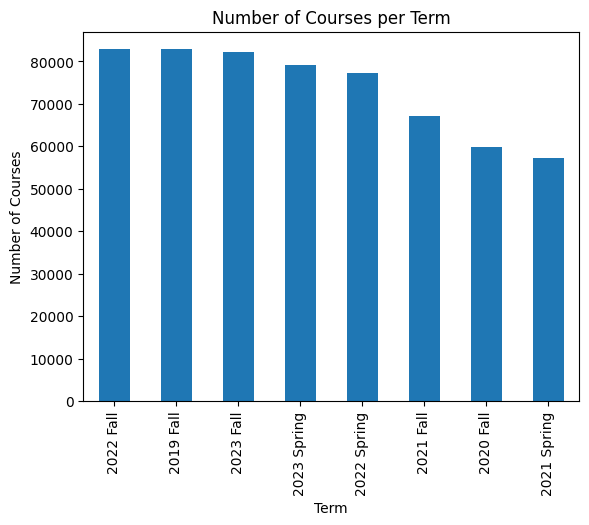


Number of feedback records per course (top 10):
Title
SOC-STD 10A-Introduction to Social Studies 001                                                                    6247
LIFESCI 1A-An Integrated Introduction to the Life Sciences: Chemistry, Molecular Biology, and Cell Biology 001    4116
ECON 10A-Principles of Economics (Microeconomics) 001                                                             4003
COMPSCI 50-Introduction to Computer Science 001                                                                   3510
BBS 330-Critical Thinking and Research Proposal Writing 001                                                       3502
BBS 230-Qualitative and Quantitative Analysis of the Biological Literature 001                                    3080
CELLBIO 201-Principles of Cell Biology 001                                                                        2788
SOC-STD 10B-Introduction to Social Studies 001                                                                  

In [13]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt

# Load the data
with open('course_data.json', 'r') as f:
    course_data = json.load(f)

# Flatten the data into a DataFrame
flattened_data = []
for course in course_data:
    feedback = course.get('Feedback', {})
    for table_name, records in feedback.items():
        for record in records:
            record.update(course)  # Add course-level data to each record
            flattened_data.append(record)

# Convert to DataFrame
df = pd.DataFrame(flattened_data)

# Display the first few rows to understand the structure
print("Data sample:")
print(df.head())

# General exploration
# 1. Most common departments
common_departments = Counter(df['Department']).most_common(10)
print("\nMost common departments:")
for dept, count in common_departments:
    print(f"{dept}: {count} courses")

# 2. Most frequent instructors
if 'Instructor Name' in df.columns:
    common_instructors = Counter(df['Instructor Name']).most_common(10)
    print("\nMost frequent instructors:")
    for instructor, count in common_instructors:
        print(f"{instructor}: {count} occurrences")

# 3. Courses per term
if 'Term' in df.columns:
    term_counts = df['Term'].value_counts()
    print("\nNumber of courses per term:")
    print(term_counts)

    # Plot courses per term
    term_counts.plot(kind='bar')
    plt.title('Number of Courses per Term')
    plt.xlabel('Term')
    plt.ylabel('Number of Courses')
    plt.show()

# 4. Number of feedback records per course
course_feedback_counts = df['Title'].value_counts()
print("\nNumber of feedback records per course (top 10):")
print(course_feedback_counts.head(10))

# 5. Optional: General statistics
print("\nGeneral statistics:")
print(df.describe(include='all'))
